# Building a multitask model with Keras



## The dataset

The UTKFace dataset is a large dataset composed of over 20 thousand face images with their respectivce annotations of age, gender and ethnicity. The images are properly cropped into the face region, but display some variations in pose, illumination, resolution, etc.

In order to retrieve the annotations of each record, we need to parse the filenames. Each record is stored in the following format: `[age]_[gender]_[race]_[date&time].jpg`

Where:
    - age is an integer from 0 to 116
    - gender is an integer in which 0 represents male and 1 represents female
    - race is an integer from 0 to 4, denoting white, black, asian, indian and others, respectively
    - date and time, denoting when the picture was taken
    
If you want to know more about this dataset, please check their [website](https://www.kaggle.com/jangedoo/utkface-new).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dataset_folder_name = '/content/drive/MyDrive/kaggle_dataset_images/utkface_aligned_cropped/UTKFace'

TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 198

dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((g, i) for i, g in dataset_dict['race_id'].items())

In [3]:
import numpy as np 
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

The following code aims to create pandas dataframe with necessary information.

In [4]:
def parse_dataset(dataset_path, ext='jpg'):

    def parse_info_from_file(path):
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']
    df = df.dropna()
    
    return df

In [6]:
# dataset too large for drive, sometimes ends with error A Google Drive timeout has occurred, if that is your case just rerun
df = parse_dataset(dataset_folder_name)
df

,age,gender,race,file
0,67.0,male,white,/content/drive/MyDrive/kaggle_dataset_images/u...
1,8.0,male,white,/content/drive/MyDrive/kaggle_dataset_images/u...
2,85.0,female,white,/content/drive/MyDrive/kaggle_dataset_images/u...
3,66.0,female,white,/content/drive/MyDrive/kaggle_dataset_images/u...
4,78.0,male,white,/content/drive/MyDrive/kaggle_dataset_images/u...
...,...,...,...,...
23703,10.0,female,black,/content/drive/MyDrive/kaggle_dataset_images/u...
23704,16.0,male,white,/content/drive/MyDrive/kaggle_dataset_images/u...
23705,15.0,female,asian,/content/drive/MyDrive/kaggle_dataset_images/u...
23706,10.0,male,white,/content/drive/MyDrive/kaggle_dataset_images/u...


# Data visualization

So, there are three targets:

*  Age: range from 1 to 116
* Ethnicity: 0 - White, 1 - Black, 2 - Asian, 3 - Indian, 4 - Other
* Gender: 0 - male, 1 - female 

In [8]:
import plotly.graph_objects as go
## calculating distributions
age_dist = df['age'].value_counts()
ethnicity_dist = df['race'].value_counts().rename(index={0:'Male',1:'Female'})
gender_dist = df['gender'].value_counts()

def ditribution_plot(x,y,name):
    fig = go.Figure([
        go.Bar(x=x, y=y)
    ])

    fig.update_layout(title_text=name)
    fig.show()

### Race distribution

In [16]:
ditribution_plot(x=ethnicity_dist.index, y=ethnicity_dist.values, name='Race Distribution')

From a quick glance, we can see that we have almost half of the samples being from the white race, so we can expect to have a great accuracy on this given class. Other races such as black, indian and asian also show a good number of samples, probably leading us to good accuracy numbers. The race 'others' (hispanics, latinos, etc) on the other side, show a small number of samples, which may lead to a small accuracy.

### Gender distribution

In [ ]:
ditribution_plot(x=gender_dist.index, y=gender_dist.values, name='Gender Distribution')

For both male and female samples, we have quite a good balanced number of records, so we should have a great accuracy for both classes when using our model.

### Age distribution

Let's also plot how our age feature is distributed over the dataset by using a simple histogram with 20 bins.

In [12]:
import plotly.express as px
fig = px.histogram(df, x="age", nbins=20)
fig.update_layout(title_text='Age distribution')
fig.show()

In [17]:
bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
names = ['<10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+']

age_binned = pd.cut(df['age'], bins, labels=names).value_counts()
ditribution_plot(x=age_binned.index, y=age_binned.values, name='Age Distribution')

We can observe that our dataset is mostly composed of individuals which age varies between 20 and 30 years, followed by individuals ranging from 30-40 years and then 40-60 years old. These groups represent around 70% of our dataset, so we can believe that we are going to have a good accuracy on predicting individuals in these ranges.


# Data preparation

In order to input our data to our Keras multi-output model, we will create a helper object to work as a data generator for our dataset. This will be done by generating batches of data, which will be used to feed our multi-output model.

In [19]:
from keras.utils import to_categorical
from PIL import Image

# !!!no such thing was needed in single task model
class UtkFaceDataGenerator():

    def __init__(self, df):
        self.df = df
        
    def generate_split_indexes(self):
        p = np.random.permutation(len(self.df))
        train_up_to = int(len(self.df) * TRAIN_TEST_SPLIT)
        train_idx = p[:train_up_to]
        test_idx = p[train_up_to:]

        train_up_to = int(train_up_to * TRAIN_TEST_SPLIT)
        train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]
        
        # converts alias to id
        self.df['gender_id'] = self.df['gender'].map(lambda gender: dataset_dict['gender_alias'][gender])
        self.df['race_id'] = self.df['race'].map(lambda race: dataset_dict['race_alias'][race])

        self.max_age = self.df['age'].max()
        
        return train_idx, valid_idx, test_idx
    
    def preprocess_image(self, img_path):
        im = Image.open(img_path)
        im = im.resize((IM_WIDTH, IM_HEIGHT))
        im = np.array(im) / 255.0
        
        return im
        
    def generate_images(self, image_idx, is_training, batch_size=16):
        # arrays to store our batched data
        images, ages, races, genders = [], [], [], []
        while True:
            for idx in image_idx:
                person = self.df.iloc[idx]
                
                age = person['age']
                race = person['race_id']
                gender = person['gender_id']
                file = person['file']
                
                im = self.preprocess_image(file)
                
                ages.append(age / self.max_age)
                races.append(to_categorical(race, len(dataset_dict['race_id'])))
                genders.append(to_categorical(gender, len(dataset_dict['gender_id'])))
                images.append(im)
                
                # yielding condition
                if len(images) >= batch_size:
                    yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                    images, ages, races, genders = [], [], [], []
                    
            if not is_training:
                break
                
data_generator = UtkFaceDataGenerator(df)
train_idx, valid_idx, test_idx = data_generator.generate_split_indexes()

In [21]:
# just to check data distribution between train, valid, test
# train and valid are used during model fitting
# test used for predictions on unseen data
print(len(train_idx))
print(len(valid_idx))
print(len(test_idx))

11615
4978
7112


## Building our model

In this step, we will define our multi-output Keras model. Our model will be composed of three major branches, one for each available feature: age, gender and race. The default structure for our convolutional layers is based on a Conv2D layer with a ReLU activation, followed by a BatchNormalization layer, a MaxPooling and finally a Dropout layer. Each of these default layers is then followed by the final layer for each feature, composed by a Dense layer.

These default layers are defined on the make_default_hidden_layers method, which will be reused on building each of the branches of our model.

In [27]:
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
import tensorflow as tf

class UtkMultiOutputModel():
    # similar to my previous model in fastai2 
    # Used to generate our multi-output model. This CNN contains three branches, one for age, other for 
    # sex and another for race. Each branch contains a sequence of Convolutional Layers that is defined
    # on the make_default_hidden_layers method.
    def make_default_hidden_layers(self, inputs):
        # Used to generate a default set of hidden layers. The structure used in this network is defined as:
        # Conv2D -> BatchNormalization -> Pooling -> Dropout
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.1)(x)

        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.1)(x)

        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.1)(x)

        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.1)(x)

        return x

    def build_race_branch(self, inputs, num_races):
        # Used to build the race branch of our face recognition network.
        # This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        # followed by the Dense output layer.
        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_races)(x)
        x = Activation("softmax", name="race_output")(x)

        return x

    def build_gender_branch(self, inputs, num_genders=2):
        # Used to build the gender branch of our face recognition network.
        # This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        # followed by the Dense output layer.        
        x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)

        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_genders)(x)
        x = Activation("sigmoid", name="gender_output")(x)

        return x

    def build_age_branch(self, inputs):   
        # Used to build the age branch of our face recognition network.
        # This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        # followed by the Dense output layer.
        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation("linear", name="age_output")(x)

        return x

    def assemble_full_model(self, width, height, num_races):
        # Used to assemble our multi-output model CNN.
        input_shape = (height, width, 3)

        inputs = Input(shape=input_shape)

        age_branch = self.build_age_branch(inputs)
        race_branch = self.build_race_branch(inputs, num_races)
        gender_branch = self.build_gender_branch(inputs)

        model = Model(inputs=inputs,
                     outputs = [age_branch, race_branch, gender_branch],
                     name="face_net")

        return model
    
model = UtkMultiOutputModel().assemble_full_model(IM_WIDTH, IM_HEIGHT, num_races=len(dataset_dict['race_alias']))

*Let*'s give a look into our model structure and summary, to have a better understanding of what we are building. Also to check for early errors.

In [26]:
# It can be used to reconstruct the model identically.
# Loads latest model, in fastai2 there was easy way to save just the best result, here it did not work
# !!! notice that this rewrites model variable

# from tensorflow import keras
# model = keras.models.load_model("/content/drive/MyDrive/model_checkpoint")


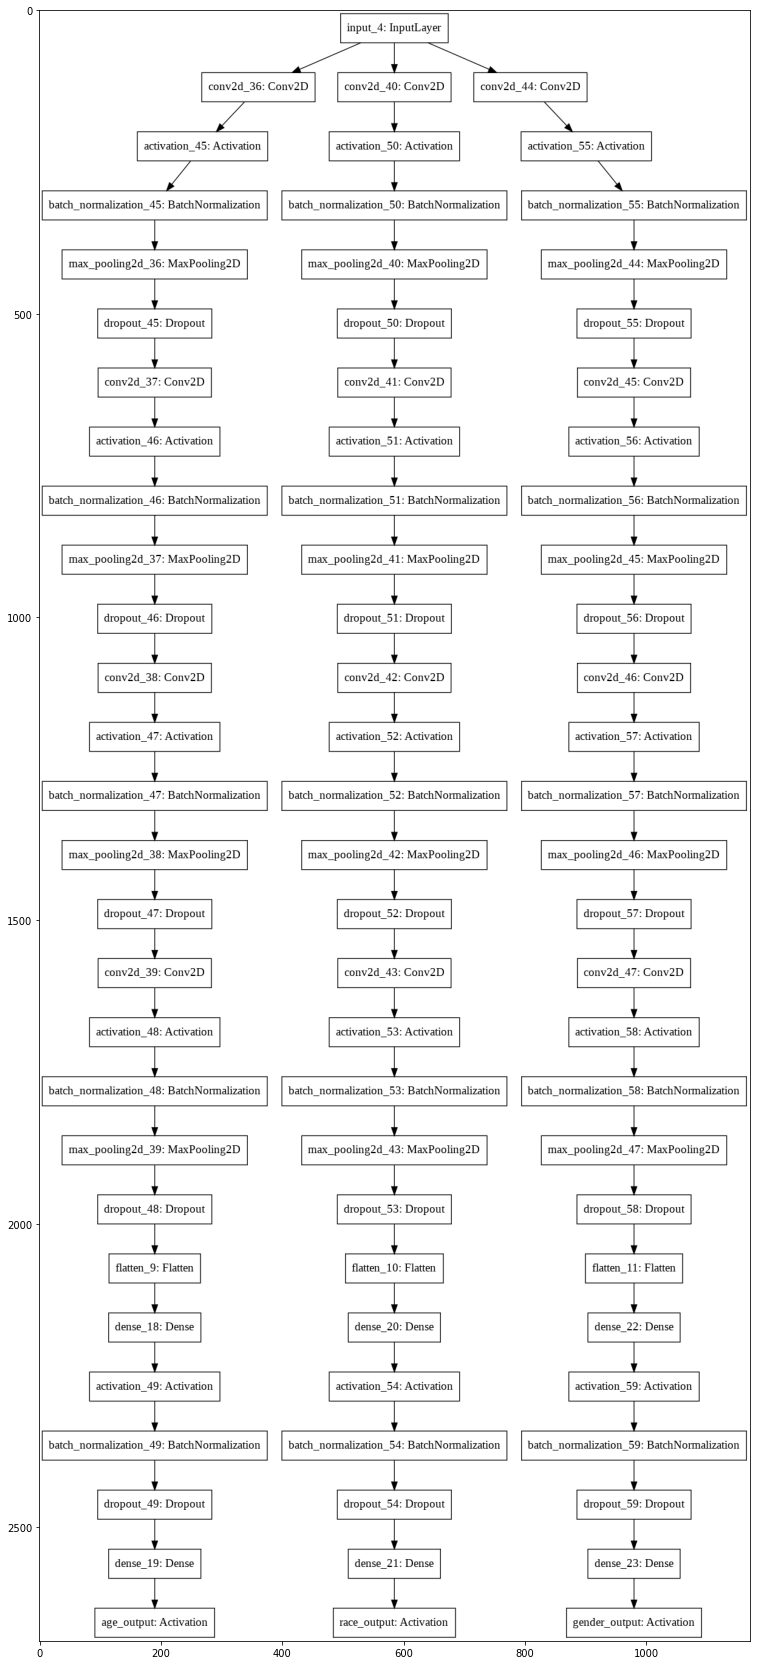

In [28]:
%matplotlib inline

from keras.utils import plot_model
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

plot_model(model, to_file='/content/drive/MyDrive/model.png')
img = mpimg.imread('/content/drive/MyDrive/model.png')

plt.figure(figsize=(40, 30))
plt.imshow(img)

In [29]:
model.summary()

Model: "face_net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 198, 198, 3) 0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 198, 198, 16) 448         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 198, 198, 16) 448         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 198, 198, 16) 448         input_4[0][0]                    
___________________________________________________________________________________________

## Training our model

Now it's time to train our multi-output model, once we already have everything done. But before doing it, we need to compile our model. For this step, let's use a learning rate of 0.0004 and an Adam optimizer. We will also use custom loss weights for each feature and a custom loss function for each feature.

When building our optimizer, let's use a decay based on the learning rate divided by the number of epochs, so we will slowly be decreasing our learning rate over the epochs.

In [30]:
from keras.optimizers import Adam, SGD

init_lr = 1e-4
epochs = 100

opt = Adam(lr=init_lr, decay=init_lr / epochs)
# opt = SGD(lr=init_lr, decay=init_lr / epochs)

model.compile(optimizer=opt, 
              loss={
                  'age_output': 'mse', 
                  'race_output': 'categorical_crossentropy', 
                  'gender_output': 'binary_crossentropy'},
              loss_weights={
                  'age_output': 4., 
                  'race_output': 1.5, 
                  'gender_output': 0.5},
              metrics={
                  'age_output': 'mae', 
                  'race_output': 'accuracy',
                  'gender_output': 'accuracy'})

And now let's train our model with a batch size of 64 for both valid and train sets. We will be using a ModelCheckpoint callback in order to save the model on disk at the end of each epoch.

In [37]:
from keras.callbacks import ModelCheckpoint

batch_size = 64
valid_batch_size = 64
train_gen = data_generator.generate_images(train_idx, is_training=True, batch_size=batch_size)
valid_gen = data_generator.generate_images(valid_idx, is_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("/content/drive/MyDrive/model_checkpoint", monitor='val_loss')
]

# history = model.fit(train_gen,
#                     steps_per_epoch=10,
#                     epochs=epochs,
#                     callbacks=callbacks,
#                     validation_data=valid_gen,
#                     validation_steps=10)

# in fastaiv2 fit one cycle was used, in keras is just some weird libraries with plenty of issues
history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

Epoch 1/100
181/181 [==============================] - 71s 390ms/step - loss: 4.4121 - age_output_loss: 0.7303 - race_output_loss: 0.8862 - gender_output_loss: 0.3235 - age_output_mae: 0.6532 - race_output_accuracy: 0.6959 - gender_output_accuracy: 0.8677 - val_loss: 3.8744 - val_age_output_loss: 0.5700 - val_race_output_loss: 0.9579 - val_gender_output_loss: 0.3154 - val_age_output_mae: 0.3096 - val_race_output_accuracy: 0.6847 - val_gender_output_accuracy: 0.8722
Epoch 2/100
181/181 [==============================] - 70s 385ms/step - loss: 3.9851 - age_output_loss: 0.6383 - race_output_loss: 0.8506 - gender_output_loss: 0.3123 - age_output_mae: 0.6113 - race_output_accuracy: 0.7117 - gender_output_accuracy: 0.8739 - val_loss: 3.8551 - val_age_output_loss: 0.5831 - val_race_output_loss: 0.9169 - val_gender_output_loss: 0.2949 - val_age_output_mae: 0.3024 - val_race_output_accuracy: 0.7080 - val_gender_output_accuracy: 0.8782
Epoch 3/100
181/181 [==============================] - 70s 3

In [38]:
# model.save("/content/drive/MyDrive/my_model_same_as_fastai")


INFO:tensorflow:Assets written to: /content/drive/MyDrive/my_model_same_as_fastai/assets


Let's plot our losses and accuracy curves for each feature:

### Race accuracy

In [39]:
import plotly.graph_objects as go

plt.clf()
fig = go.Figure()
print(history.history)
fig.add_trace(go.Scatter(
                    y=history.history['race_output_accuracy'],
                    name='Train'))


fig.update_layout(height=450, 
                  width=600,
                  title='Accuracy for race feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')

fig.write_html('acc_race.html', include_plotlyjs='cdn')

fig.show()

{'loss': [4.412111282348633, 3.9851198196411133, 3.589102268218994, 3.1960015296936035, 2.8904449939727783, 2.6736159324645996, 2.427546739578247, 2.1693062782287598, 2.0308849811553955, 1.8111133575439453, 1.6808499097824097, 1.5588852167129517, 1.4552161693572998, 1.3713877201080322, 1.2858951091766357, 1.2185865640640259, 1.1467007398605347, 1.1015220880508423, 1.065337896347046, 1.0260189771652222, 0.9765734672546387, 0.9589253067970276, 0.9196006059646606, 0.8948950171470642, 0.884204089641571, 0.8632544279098511, 0.8306058049201965, 0.8142561316490173, 0.8138732314109802, 0.7864682674407959, 0.7625547647476196, 0.7625908851623535, 0.740117609500885, 0.7286155819892883, 0.7032193541526794, 0.7038944959640503, 0.6832289695739746, 0.665428638458252, 0.6613405346870422, 0.6474997997283936, 0.6362819075584412, 0.6248064041137695, 0.6012580394744873, 0.5976393818855286, 0.5836131572723389, 0.5533080101013184, 0.5633309483528137, 0.5463056564331055, 0.5344958901405334, 0.516831278800964

<Figure size 432x288 with 0 Axes>

### Gender accuracy

In [40]:
plt.clf()

fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['gender_output_accuracy'],
                    name='Train'))


fig.update_layout(height=450, 
                  width=600,
                  title='Accuracy for gender feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')

fig.write_html('acc_gender.html', include_plotlyjs='cdn')

fig.show()

<Figure size 432x288 with 0 Axes>

### Age Mean Absolute Error

In [41]:
plt.clf()

fig = go.Figure()
fig.add_trace(go.Scattergl(
                    y=history.history['age_output_mae'],
                    name='Train'))


fig.update_layout(height=450, 
                  width=600,
                  title='Mean Absolute Error for age feature',
                  xaxis_title='Epoch',
                  yaxis_title='Mean Absolute Error')

fig.write_html('mae_age.html', include_plotlyjs='cdn')

fig.show()

<Figure size 432x288 with 0 Axes>

### Overall loss

In [42]:
fig = go.Figure()
fig.add_trace(go.Scattergl(
                    y=history.history['loss'],
                    name='Train'))


fig.update_layout(height=450, 
                  width=600,
                  title='Overall loss',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')

fig.write_html('overall_loss.html', include_plotlyjs='cdn')

fig.show()

## Evaluating multitask model on the test set

In order to assess how our model performs on the test set, let's use our UTK data generator class, but this time using the test indexes. We will then call the predict_generator method from our trained model, which will output our the predictions for the test set.

Test set means data that was never seen by my NN before

In [43]:
test_batch_size = 64
test_generator = data_generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
age_pred, race_pred, gender_pred = model.predict(test_generator, steps=len(test_idx)//test_batch_size)

Let's iterate one time over all our test samples, in order to have their labels into a single list. We will also extract the arg max of each record, in order to retrieve the top predictions and ground truths.

In [44]:
test_generator = data_generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
samples = 0
images, age_true, race_true, gender_true = [], [], [], []
for test_batch in test_generator:
    image = test_batch[0]
    labels = test_batch[1]
    
    images.extend(image)
    age_true.extend(labels[0])
    race_true.extend(labels[1])
    gender_true.extend(labels[2])
    
age_true = np.array(age_true)
race_true = np.array(race_true)
gender_true = np.array(gender_true)

race_true, gender_true = race_true.argmax(axis=-1), gender_true.argmax(axis=-1)
race_pred, gender_pred = race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1)

age_true = age_true * data_generator.max_age
age_pred = age_pred * data_generator.max_age

And finally, let's print the classification reports for each feature on the test set.

In [45]:
from sklearn.metrics import classification_report

cr_race = classification_report(race_true, race_pred, target_names=dataset_dict['race_alias'].keys())

print(cr_race)

              precision    recall  f1-score   support

       white       0.82      0.88      0.85      3071
       black       0.89      0.81      0.85      1358
       asian       0.75      0.88      0.81       977
      indian       0.74      0.70      0.72      1212
      others       0.44      0.27      0.34       486

    accuracy                           0.79      7104
   macro avg       0.73      0.71      0.71      7104
weighted avg       0.79      0.79      0.79      7104



Keep in mind that this are the results from data that was seen by the NN for the first time.

We can see that the multitask NN was able to predict black race with precision of 89%, followed by white race with 82% and then asian with 75% and indian with 74%. The race 'others' shows a precision of only 0.44, but we need to take into consideration that this group is composed of different races and ethnicities along with a small number of samples, when compared to the other groups. The weighted accuracy for this classification task is 79% 


In [46]:
cr_gender = classification_report(gender_true, gender_pred, target_names=dataset_dict['gender_alias'].keys())
print(cr_gender)

              precision    recall  f1-score   support

        male       0.91      0.89      0.90      3747
      female       0.88      0.91      0.89      3357

    accuracy                           0.90      7104
   macro avg       0.90      0.90      0.90      7104
weighted avg       0.90      0.90      0.90      7104



Males were predicted with precision of 91% and females with 88%. The weighted accuracy for gender classification task is 90% 

In [47]:
from sklearn.metrics import r2_score

print('R2 score for age: ', r2_score(age_true, age_pred))

R2 score for age:  0.5272995017753195


### Example of predictions

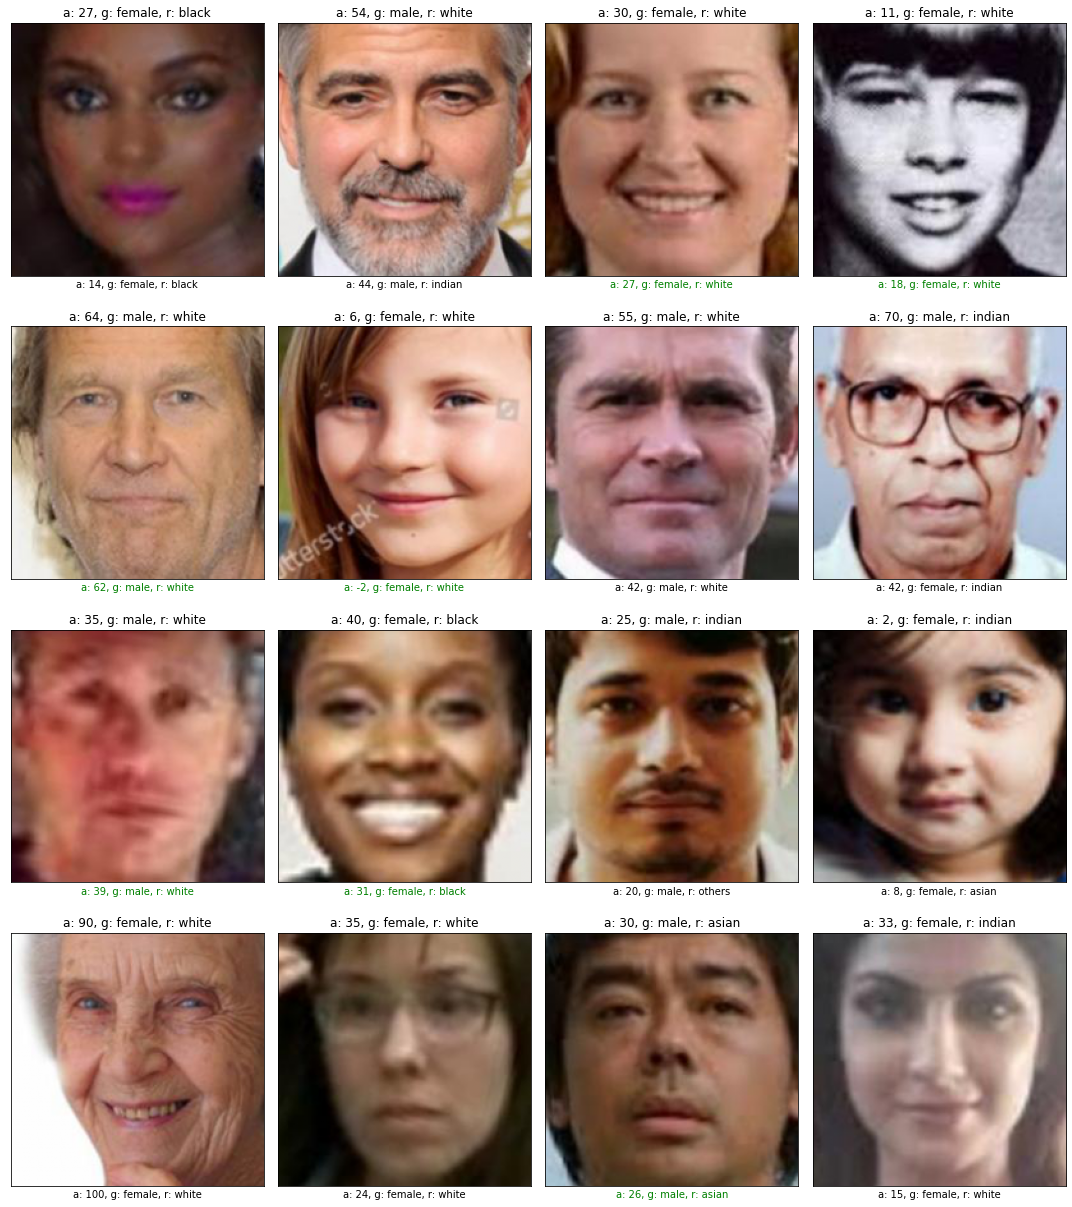

In [48]:
import math
n = 16
random_indices = np.random.permutation(n)
n_cols = 4
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 17))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(images[img_idx])
    
    cur_age_pred = age_pred[img_idx]
    cur_age_true = age_true[img_idx]
    
    cur_gender_pred = gender_pred[img_idx]
    cur_gender_true = gender_true[img_idx]
    
    cur_race_pred = race_pred[img_idx]
    cur_race_true = race_true[img_idx]
    
    age_threshold = 10
    if cur_gender_pred == cur_gender_true and cur_race_pred == cur_race_true and abs(cur_age_pred - cur_age_true) <= age_threshold:
        ax.xaxis.label.set_color('green')
    elif cur_gender_pred != cur_gender_true and cur_race_pred != cur_race_true and abs(cur_age_pred - cur_age_true) > age_threshold:
        ax.xaxis.label.set_color('red')
    
    ax.set_xlabel('a: {}, g: {}, r: {}'.format(int(age_pred[img_idx]),
                            dataset_dict['gender_id'][gender_pred[img_idx]],
                               dataset_dict['race_id'][race_pred[img_idx]]))
    
    ax.set_title('a: {}, g: {}, r: {}'.format(int(age_true[img_idx]),
                            dataset_dict['gender_id'][gender_true[img_idx]],
                               dataset_dict['race_id'][race_true[img_idx]]))
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
plt.savefig('preds.png')

# References

UTK Face Dataset: https://www.kaggle.com/jangedoo/utkface-new

Keras Multi-output documentation: https://keras.io/getting-started/functional-api-guide/

SanjayaSubedi post on multi-output model: https://sanjayasubedi.com.np/deeplearning/multioutput-keras/

PyImageSearch post on FashionNet: https://www.pyimagesearch.com/2018/06/04/keras-multiple-outputs-and-multiple-losses/

Plotly: https://plot.ly/